# <center>Interior-point methods</center>
### <center>Alfred Galichon and Antoine Jacquet (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass on linear programming and economic applications</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass on linear programming and economic applications. https://github.com/math-econ-code/mec_linprog

## Linear programming: interior-point methods

### Learning objectives

* Primal-dual interior-point method

### References

* Freund & Vera (1996). *Interior-Point Methods for Linear Optimization.* Lecture notes.
* Wright. *Linear Programming: Interior-Point Methods.* Lecture notes.

### Background

In the previous lecture, we saw that the simplex algorithm finds a solution to a linear programming problem by moving along the edges of the feasible set.
While this is effective with most practical cases, the worst-case complexity of the simplex algorithm is exponential.

*Interior-point methods* were developed starting from the 1980s as a polynomial-complexity alternative to the simplex method.
As the name suggests, and contrary to the simplex algorithm, *interior-point methods* move through the interior of the feasible set to reach a solution.

Let's begin by loading the usual packages.

In [1]:
!pip install gurobipy
import pandas as pd
import numpy as np
import scipy.sparse as spr
import gurobipy as grb
import sympy
from sympy.solvers import solve
from sympy import *
import matplotlib.pyplot as plt
from tabulate import tabulate

def plot_path_so_far(the_path):
    x1, x2 = np.meshgrid(np.linspace(-0.2, 1.4, 400), np.linspace(-0.2, 1.4, 400))
    feasible_region = (2 * x1 + x2 <= 2) & (x1 + 2 * x2 <= 2) & (x1 >= 0) & (x2 >= 0)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.contourf(x1, x2, np.where(feasible_region, x1+x2, np.nan), 50, alpha = 0.5, cmap='gray_r', levels=30)
    plt.text(0.4, 0.4, 'Feasible solutions', color = 'white', ha='center', va='center')
    ax.plot(x1[0, :], 2 - 2*x1[0, :], label='z1 = 0')
    ax.plot(2 - 2*x2[:, 0], x2[:, 0], label='z2 = 0')
    ax.plot([a for (a,_) in the_path], [b for (_,b) in the_path], 'r--', label='Algorithm path')
    ax.scatter([a for (a,_) in the_path], [b for (_,b) in the_path], color='red')
    ax.set_xlim(-0.2, 1.4), ax.set_ylim(-0.2, 1.4)
    ax.set_xlabel('x1'), ax.set_ylabel('x2')
    ax.spines[['left', 'bottom']].set_position('zero')
    ax.spines[['right', 'top']].set_color('none')
    ax.legend()
    plt.show()

## The standard problem

Let $c \in \mathbf{R}^n$, $b \in \mathbf{R}^m$, and $A$ a $m\times n$ matrix, and consider the standard-form linear programming problem

\begin{align}
P : \max_{x \geq 0}  & ~ c^{\top} x \\
\text{s.t.} & ~ Ax = b.
\end{align}

Using slack variables $s_j$, the dual is

\begin{align}
D : \min_{y \in \mathbf R^m, s \geq 0}  & ~ b^{\top} y \\
\text{s.t.} & ~ A^\top y - s = c.
\end{align}





The KKT conditions for $P$ are

* $Ax = b$, $x \geq 0$ (Primal feasibility)
* $A^\top y - s = c$, $s \geq 0$ (Dual feasibility)
* $\forall j, ~ s_j ~ x_j = 0$ (Complementary slackness).

This is a system of equations with unknowns $(x, y, s)$, but it is nonlinear because of the complemetary slackness condition.

A common way to find a solution to a nonlinear system is Netwon's method:
* take an initial guess $x_0$,
* linearize the system of equations around $x_0$,
* find the solution $x_1$ to this linearized system.

Under regularity conditions, $x_1$ will be closer to the actual solution of the problem than the initial guess $x_0$.
Thus, iterating Newton's method would yield our desired solution.

However, we cannot implement this method here.
This is because of the positivity constraints $x \geq 0, s \geq 0$.
Indeed, with Newton's method we do not control the search range for $x$ and $s$.
We are therefore likely to converge towards spurious solutions of the KKT system (i.e. such that the positivity constraints are violated).

## Logarithmic barrier

To circumvent this issue with the posivity constraints, we will add a penalty to our objective which will ensure that we remain within the feasible region.
We define a class of problems parametrized by $\theta > 0$:

\begin{align}
P(\theta) : \max_{x > 0}  & ~ c^{\top} x
+ \theta \sum_j \ln(x_j) \\
\text{s.t.} & ~ Ax = b.
\end{align}

Intuitively, when $\theta$ approaches 0, the solution of $P(\theta)$ should approach that of $P$. (We will verify this shortly.)

The KKT conditions for $P(\theta)$ are
* $Ax = b$, $x>0$ (Primal feasibility)
* $A^\top y + \theta ~ \frac{1}{x}  = c$ (Stationarity)

where we have abused notation by denoting $\frac{1}{x} = \big(\frac{1}{x_j}\big)_j$.

Now let's just rewrite these KKT conditions by introducing the variables $s_j = \theta / x_j$:
* $Ax = b$, $x > 0$
* $A^\top y - s  = c$
* $\forall j, ~ s_j ~ x_j = \theta$.

We find a system very similar to that of the KKT conditions for $P$. By introducing the logarithmic barrier, we have essentially relaxed the complementary slackness conditions to $s_j ~ x_j = \theta$.

Furthermore, the logarithmic barrier guarantees that we will not explore the non-feasible space in our search for a solution.
(Note that in practice this also requires choosing a large enough $\theta$, but we will not cover this here.)

### Duality gap

If $(x_\theta, y_\theta, s_\theta)$ is a solution to $P(\theta)$, then it is feasible for both $P$ and $D$ (verify) and the duality gap is

\begin{align*}
b^\top y_\theta - c^\top x_\theta
&= (A x_\theta)^\top y_\theta - x_\theta^\top c
= x_\theta^\top (A^\top y_\theta - c) \\
&= x_\theta^\top s_\theta \\
&= n \theta
\end{align*}

where $n$ is the dimension of $x$.

This motivates us to look for solutions to $P(\theta)$ for smaller and smaller values of $\theta$. As $\theta \rightarrow 0$, $(x_\theta, y_\theta, s_\theta)$ should converge towards a point which is primal- and dual-feasible and with no duality gap, i.e. solution of the original primal-dual problem.

The set of solutions $\{ (x_\theta, y_\theta, s_\theta) \mid \theta > 0 \}$ is called the *central path*.

# The algorithm

We can now describe roughly the algorithm we want to implement:

---

**Step 0.** Choose a starting point $(x,y,s)$ along with an initial value for $\theta$.

**Step 1.** Use $(x,y,s)$ to find an approximate solution $(x', y', s')$ to the problem $P(\theta)$ via Newton's method.

**Step 2.** Shrink $\theta$ to $\theta' = \alpha \theta$, where $0 < \alpha < 1$.

Go back to step 1 with the new values $(x', y', s')$ and $\theta'$.

---

By finding an approximate solution to $P(\theta)$, shrinking $\theta$, and repeating this process, we hope that our algorithm will follow an itinerary close to the central path, and thus converge towards the solution of the initial problem $P$.

*Remark:* In practice the shrinkage coefficient $\alpha$ must be chosen carefully, in order to ensure convergence of the algorithm.

### Approximate solution to the KKT system

Let's see how we can use the KKT system of problem $P(\theta)$ to obtain an approximate solution.

Consider an interior, feasible starting point $(x, y, s)$ to the problem $P(\theta)$. In particular, it satisfies
* $Ax = b$
* $A^\top y - s  = c$.

Ideally, our new iterate $(x + \Delta x, y + \Delta y, s + \Delta s)$ would be a solution of $P(\theta)$ and should thus verify
* $A(x + \Delta x) = b$
* $A^\top (y + \Delta y) - (s + \Delta s)  = c$
* $\forall j, ~ (s + \Delta s)_j ~ (x + \Delta x)_j = \theta$.

Because $(x, y, s)$ is both primal- and dual-feasible, this simplifies to
* $A \Delta x = 0$
* $A^\top \Delta y - \Delta s  = 0$
* $\forall j, ~ (s + \Delta s)_j ~ (x + \Delta x)_j = \theta$.

We will find an approximate solution to this system by ignoring the only nonlinear term, $\Delta s_j ~ \Delta x_j$ (this is akin to using Newton's method; see details at the end).
Our approximate system becomes
* $A \Delta x = 0$
* $A^\top \Delta y - \Delta s  = 0$
* $\forall j, ~ s_j ~ x_j + s_j ~ \Delta x_j + \Delta s_j ~ x_j = \theta \quad \iff \quad \text{diag}(s) ~ x + \text{diag}(s) \Delta x + \text{diag}(x) \Delta s = \theta 1_n.$


Note that if we manage to solve this system, our new iterate $(x + \Delta x, y + \Delta y, s + \Delta s)$ will still be primal- and dual-feasible (verify).

The only difficulty is finding $\Delta y$. Once this is done, we can plug it in to find $\Delta s$, and then $\Delta x$.

Left-multiply the last condition by $A ~ \text{diag}(s)^{-1}$ to get

\begin{equation}
A x + A \Delta x + A ~ \text{diag}(s)^{-1} \text{diag}(x) \Delta s = \theta A ~ \text{diag}(s)^{-1} 1_n.
\end{equation}

Using $A \Delta x = 0$, $Ax = b$, $\Delta s = A^\top \Delta y$ and reorganizing yields

\begin{equation}
\left[ A ~ \text{diag}(s)^{-1} \text{diag}(x) A^\top \right] \Delta y = \theta A ~ \text{diag}(s)^{-1} 1_n - b.
\end{equation}


Hence the algorithm step is given by:

* $\Delta y$ solves the linear system: $\left[ A ~ \text{diag}(s)^{-1} \text{diag}(x) A^\top \right] \Delta y = \theta A ~ \text{diag}(s)^{-1} 1_n - b$
* $\Delta s = A^\top \Delta y$
* $\Delta x = - x - \text{diag}(s)^{-1} \text{diag}(x) \Delta s +  \theta \text{diag}(s)^{-1} 1_n$

## Implementation

We will code the IPM algorithm described above, while following along using the LP example from our previous lecture. Its standard form was

\begin{align*}
\max_{x_1, x_2, x_3, x_4 \geq 0}  & ~ x_1 + x_2 \\
\text{s.t.} & ~ 2 x_1 + x_2 + x_3 = 2  \\
            & ~ x_1 + 2 x_2 + x_4 = 2
\end{align*}

where $x_3$ and $x_4$ are the slack variables.

We begin by defining a Python class `InteriorPoint` to use with our algorithm. On top of the data from the LP problem ($A$, $b$ and $c$), this class includes the current point (including the current value of $\theta$) in the solution search. We also attach an appropriate shrinkage coefficient $\alpha$ to this class, according to a formula provided in Freund & Vera (1996).

In [2]:
class InteriorPoint():
    def __init__(self, A_i_j, b_i, c_j, current_point=None):
        self.A_i_j = A_i_j
        self.b_i = b_i
        self.c_j = c_j
        self.current_point = current_point
        self.α = 1 - (1/8)/(1/5 + np.sqrt(len(c_j))) # shrinkage coeff αs given by Freund & Vera

    #def strictly_feasible_solution(self):
    #    x_j = np.linalg.lstsq(A_i_j, b_i) # Ax < b
    #    s_j = .01*np.ones(len(c))
    #    y_i = np.linalg.lstsq(A_i_j.T, s_j + c_j) # A.T y > c
    #    return np.concatenate((x,y,s))

LP_example = InteriorPoint(A_i_j = np.array([[2, 1, 1, 0], [1, 2, 0, 1]]),
                      b_i = [2,2],
                      c_j = np.array([1,1,0,0]))

LP_example.α

0.9431818181818182

To initialize our algorithm, we need a starting point which is a strictly feasible solution to the primal-dual problem.

In our example, a strictly feasible solution (i.e. such that $x > 0$) is for instance

$x_1 = .20$, $x_2 = .01$, $x_3 = 1.59$, $x_4 = 1.78$.

For the dual, a strictly feasible solution (i.e. such that $s > 0$) is

$y_1 = y_2 = 1$ \\
$s_1 = s_2 = 2$, $s_3 = s_4 = 1$.

We also choose $\theta = .5$ (somewhat arbitrarily) to start with.

We define this starting point below, and we represent it in the $(x_1, x_2)$ space.


True
True


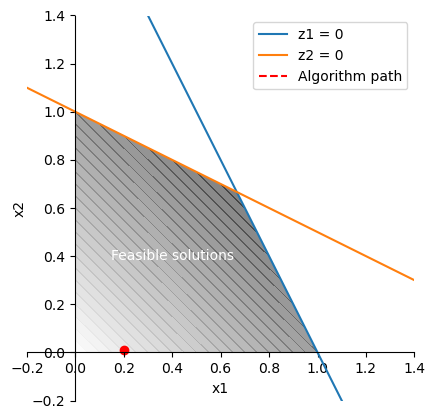

In [3]:
x_j = np.array([.20, .01, 1.59, 1.78])
y_i = np.array([1, 1])
s_j = np.array([2, 2, 1, 1])

print(all(LP_example.A_i_j @ x_j == LP_example.b_i)) # verify that Ax = b
print(all(LP_example.A_i_j.T @ y_i - s_j == LP_example.c_j)) # verify that A.T y - s = c

starting_point = [x_j, y_i, s_j, .5] # x, y, s, θ
LP_example.current_point = starting_point

the_path_so_far = [starting_point[0][:2]]
plot_path_so_far(the_path_so_far)

We now encode the computation of the new iterate:

* $\Delta y$ solves the linear system: $\left[ A ~ \text{diag}(s)^{-1} \text{diag}(x) A^\top \right] \Delta y = \theta A ~ \text{diag}(s)^{-1} 1_n - b$
* $\Delta s = A^\top \Delta y$
* $\Delta x = - x - \text{diag}(s)^{-1} \text{diag}(x) \Delta s +  \theta \text{diag}(s)^{-1} 1_n$

while also shrinking $\theta$ to $\alpha \theta$.


x1 = 0.35339926329276106
x2 = 0.25526505445227415
x3 = 1.0379364189622036
x4 = 1.1360706278026906


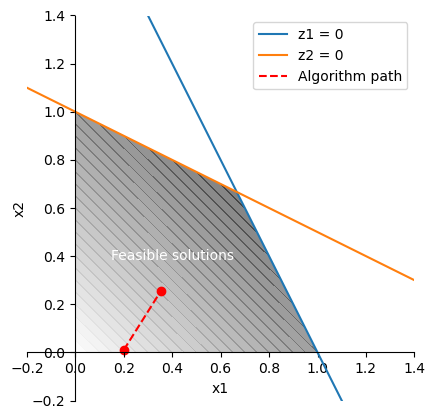

In [4]:
def InteriorPoint_update(self, verbose=0):
    x_j, y_i, s_j, θ = self.current_point
    Δy_i = np.linalg.solve(self.A_i_j @ np.diag(1/s_j) @ np.diag(x_j) @ self.A_i_j.T,
                           θ * self.A_i_j @ (1/s_j) - self.b_i)
    Δs_j = self.A_i_j.T @ Δy_i
    Δx_j = - x_j - np.diag(1/s_j) @ np.diag(x_j) @ Δs_j + θ * (1/s_j)
    self.current_point = [x_j+Δx_j, y_i+Δy_i, s_j+Δs_j, self.α*θ]
    if verbose > 0:
        for j in range(len(x_j)): print("x"+str(j+1)+" =", LP_example.current_point[0][j])
    return self.current_point

InteriorPoint.update = InteriorPoint_update

LP_example.update(verbose=1)

the_path_so_far.append(LP_example.current_point[0][:2])
plot_path_so_far(the_path_so_far)

We can now repeat this process until we are satisfied by the convergence (as measured by our tolerance level `tol`). We encode a full step of the algorithm in `IPM_loop`.

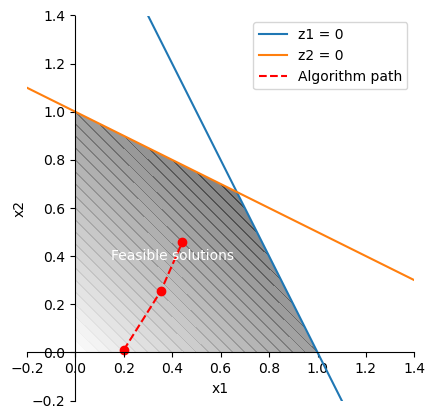

In [5]:
def InteriorPoint_loop(self, tol=1e-8, max_iter=100, verbose=0):
    current_point = self.current_point
    new_point = self.update()
    if all(abs(np.concatenate(new_point[:-1]) - np.concatenate(current_point[:-1])) < tol):
        print('Optimal solution found.\n=======================')
        if verbose > 0:
            for i in range(len(new_point[0])): print("x" + str(i+1), "=", new_point[0][i])
    else:
        if verbose > 1:
            for i in range(len(new_point[0])): print("x" + str(i+1), "=", new_point[0][i])
        return False # not finished
    return True # finished

InteriorPoint.loop  = InteriorPoint_loop

LP_example.loop(verbose=1)
the_path_so_far.append(LP_example.current_point[0][:2])
plot_path_so_far(the_path_so_far)

We can then code the complete IPM algorithm as:

Optimal solution found.
x1 = 0.6666666119505696
x2 = 0.6666666119505696
x3 = 1.6414829097265168e-07
x4 = 1.6414829097265144e-07

Value = 1.3333332239011393


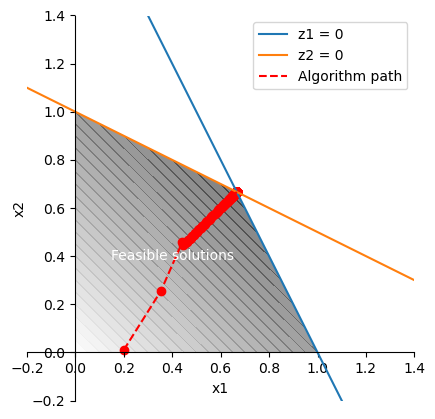

In [6]:
finished = False
while not finished:
  finished = LP_example.loop(verbose=1)
  the_path_so_far.append(LP_example.current_point[0][:2])
print('\nValue =', LP_example.c_j @ LP_example.current_point[0])

plot_path_so_far(the_path_so_far)

We do converge to the solution $x_1 = x_2 = \frac{2}{3}$. Our algorithm seems to work!

*Remarks:*
* Note the large number of iterations it took to reach the solution, compared to the simplex algorithm. This is in part because our shrinkage coefficient, $\alpha$, is very close to one.
More efficient methods exist, which allow for a much smaller shrinkage coefficient and faster convergence.
* We initially set $\theta = .5$, which seems to work here. Note that if this starting value is too small, then our algorithm may converge to spurious solutions (try it!). We are able to detect this in our simple example, but for a more complicated problem, one should be careful in choosing the starting value for $\theta$.

## Application to the diet problem

In [7]:
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/lp_stigler-diet/'
filename = 'StiglerData1939.txt'
thedata = pd.read_csv(thepath + filename, sep='\t')
thedata = thedata.dropna(how = 'all')
commodities = (thedata['Commodity'].values)[:-1]
allowance = thedata.iloc[-1, 4:].fillna(0).transpose()
N_i_j = thedata.iloc[:-1, 4:].fillna(0).transpose().values
nbi, nbj = N_i_j.shape
c_j = np.ones(nbj)
d_i = np.array(allowance)[:nbi]

Recall the dual problem in standard form, with slack variables $z_j$:

\begin{align*}
\max_{z_j \geq 0, \pi_i \geq 0} & ~ \sum_{i} d_{i} \pi_i \\
\text{s.t.} & ~ z_j  + \sum_{i} N_{ij}\pi_i= c_j .
\end{align*}

In [8]:
diet_problem = InteriorPoint(A_i_j = np.hstack((np.eye(nbj), N_i_j.T)),
                      b_i = c_j,
                      c_j = np.hstack((np.zeros(nbj), d_i)))

diet_problem.α

0.9868054640305146

We want to find a feasible starting point (i.e. such that $z_j > 0$ and $\pi_i > 0$). Because all of the coefficients $c_j$ and and $N_{ij}$ are positive, this is easily achieved by choosing $\pi_i$ small enough.

In [9]:
π_i = .0001*np.ones(nbi)
z_j = c_j - N_i_j.T @ π_i
x_k = np.hstack((z_j, π_i))

print(all(x_k > 0))

True


We also need a feasible point for the primal problem, i.e. $q$ such that $Nq \geq d$. This is achieved by taking $q$ large enough.

In [10]:
q_j = 1*np.ones(nbj)

y_j = q_j
s_k = np.hstack((y_j, N_i_j @ q_j - d_i))

print(all(s_k > 0))

True


We can now apply our algorithm to the diet problem.

In [11]:
diet_problem.current_point = [x_k, y_j, s_k, .5] # x, y, s, θ

finished = False
while not finished:
  finished = diet_problem.loop(verbose=0)
print('\nValue =', diet_problem.c_j @ diet_problem.current_point[0])

Optimal solution found.

Value = 0.10866227804798517


In [12]:
def print_optimal_diet(q_j):
    print('***Optimal solution***')
    total,thelist = 0.0, []
    for j,commodity in enumerate(commodities):
        if q_j[j] > 1e-8:
            total += q_j[j] * 365
            thelist.append([commodity,q_j[j]])
    thelist.append(['Total cost (optimal):', total])
    print(tabulate(thelist))

print_optimal_diet(diet_problem.current_point[1])

***Optimal solution***
-------------------------  -----------
1. Wheat Flour (Enriched)   0.0295191
30. Liver (Beef)            0.00189256
46. Cabbage                 0.0112144
52. Spinach                 0.00500766
69. Navy Beans Dried        0.0610286
Total cost (optimal):      39.6617
-------------------------  -----------


This is the same solution as the one we found in the first lecture. We also find the same with Gurobi:

In [13]:
dietmodel = grb.Model()
varq_j = dietmodel.addMVar(nbj)
dietmodel.Params.OutputFlag = 0
dietmodel.setObjective(varq_j.sum(), grb.GRB.MINIMIZE)
c = dietmodel.addConstr(N_i_j @ varq_j >= d_i)
dietmodel.optimize()
q_j , π_i, val = dietmodel.getAttr('X') , dietmodel.getAttr('pi'), dietmodel.getAttr('objVal')
print('\nValue =',val)


Value = 0.10866227820675686



## Details on Newton's method

We perform Newton's method from our current iterate $(x,y,s)$ on the function

\begin{equation}
  F(x, y, s) = \begin{pmatrix}
    A x - b \\
    A^\top y - s \\
    \text{diag}(s) ~ x - \theta ~ 1_n
  \end{pmatrix}.
\end{equation}

The Newton step $(\Delta x, \Delta y, \Delta s)$ is defined by

$\text J F(x,y,s) ~
\begin{pmatrix} \Delta x \\ \Delta y \\ \Delta s \end{pmatrix} = - F(x,y,s)$.

where $\text J F(x,y,s)$ is the Jacobian of $F$. It is a square matrix of dimension $2n+m$, equal to

$\text J F(x,y,s) =
\begin{pmatrix}\
A & 0_{m \times m} & 0_{m \times n} \\
0_{n \times n} & A^\top & - \text I_n \\
\text{diag}(s) & 0_{n \times m} & \text{diag}(x)
\end{pmatrix}$

Therefore

$\text J F(x,y,s) \begin{pmatrix} \Delta x \\ \Delta y \\ \Delta s \end{pmatrix} =
\begin{pmatrix}
A \Delta x \\
A^\top \Delta y - \Delta s \\
\text{diag}(s) \Delta x + \text{diag}(x) \Delta s
\end{pmatrix}$.

Furthermore, since our current iterate $(x,y,s)$ is primal- and dual-feasible,

$F(x, y, s) = \begin{pmatrix}
    0 \\
    0 \\
    \text{diag}(s) ~ x - \theta 1_n
  \end{pmatrix}$

Therefore our Newton step is equivalent to solving the linear system

\begin{cases}
A \Delta x = 0 \\
A^\top \Delta y - \Delta s = 0 \\
\text{diag}(s) ~ x + \text{diag}(s) \Delta x + \text{diag}(x) \Delta s = \theta 1_n.
\end{cases}

This is exactly the approximated system that we obtained above by removing the non-linear term.